In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [13]:
data = pd.read_csv('./data/220114/220114 kpeb2.csv', parse_dates = True)

In [14]:
data

,DateTime,Total_Consumption(W),Total_Production(W),Pvt_Supply(W),Pv1_Supply(W),Pv2_Supply(W)
0,2022-01-15 11:46:00,115,3893,562,1656,1675
1,2022-01-15 11:45:00,115,3928,576,1665,1687
2,2022-01-15 11:44:00,115,3904,570,1659,1675
3,2022-01-15 11:43:00,114,3866,529,1659,1678
4,2022-01-15 11:42:00,114,3891,542,1665,1684
...,...,...,...,...,...,...
193553,2021-08-20 14:37:00,15,0,0,0,0
193554,2021-08-20 14:36:00,15,0,0,0,0
193555,2021-08-20 14:35:00,15,0,0,0,0
193556,2021-08-20 14:34:00,15,0,0,0,0


In [15]:
all_features = data.columns.tolist()
print(all_features)

['DateTime', 'Total_Consumption(W)', 'Total_Production(W)', 'Pvt_Supply(W)', 'Pv1_Supply(W)', 'Pv2_Supply(W)']


In [16]:
df_kpeb2 = pd.DataFrame()
df_kpeb2['Time'] = data['DateTime']
df_kpeb2['Cons_kpeb2(W)'] = data['Total_Consumption(W)']
df_kpeb2['Prod_kpeb2(W)'] = data['Total_Production(W)']

df_kpeb2.head()


,Time,Cons_kpeb2(W),Prod_kpeb2(W)
0,2022-01-15 11:46:00,115,3893
1,2022-01-15 11:45:00,115,3928
2,2022-01-15 11:44:00,115,3904
3,2022-01-15 11:43:00,114,3866
4,2022-01-15 11:42:00,114,3891


In [17]:
df_kpeb2['Time'] = pd.to_datetime(df_kpeb2['Time'])

In [18]:
df_kpeb2=df_kpeb2[(df_kpeb2['Time']>='2021-09-13 00:00:00')]
df_kpeb2=df_kpeb2[(df_kpeb2['Time']<'2022-01-01 00:00:00')]

In [19]:
df_kpeb2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142356 entries, 20866 to 163221
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Time           142356 non-null  datetime64[ns]
 1   Cons_kpeb2(W)  142356 non-null  int64         
 2   Prod_kpeb2(W)  142356 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.3 MB


In [20]:
df_kpeb2['Cons_kpeb2(W)'] = df_kpeb2['Cons_kpeb2(W)'].astype(float)
df_kpeb2['Prod_kpeb2(W)'] = df_kpeb2['Prod_kpeb2(W)'].astype(float)

In [21]:
df_kpeb2=df_kpeb2.set_index('Time')
df_kpeb2=df_kpeb2.resample('1T').mean()

In [22]:
df_kpeb2['Cons_acc_kpeb2(Wh)'] = df_kpeb2['Cons_kpeb2(W)'].cumsum()*60/3600
df_kpeb2['Prod_acc_kpeb2(Wh)'] = df_kpeb2['Prod_kpeb2(W)'].cumsum()*60/3600

In [23]:
df_kpeb2['denominator'] = df_kpeb2.loc[:,['Cons_kpeb2(W)','Prod_kpeb2(W)']].min(axis=1)
df_kpeb2['denominator_acc'] = df_kpeb2.loc[:,['Cons_acc_kpeb2(Wh)','Prod_acc_kpeb2(Wh)']].min(axis=1)

In [24]:
df_kpeb2['SCF'] = df_kpeb2['denominator']/df_kpeb2['Prod_kpeb2(W)']
df_kpeb2['LCF'] = df_kpeb2['denominator']/df_kpeb2['Cons_kpeb2(W)']

In [25]:
df_kpeb2['SCF_acc'] = df_kpeb2['denominator_acc']/df_kpeb2['Prod_acc_kpeb2(Wh)']
df_kpeb2['LCF_acc'] = df_kpeb2['denominator_acc']/df_kpeb2['Cons_acc_kpeb2(Wh)']
df_kpeb2['self_sustain'] = df_kpeb2['Prod_acc_kpeb2(Wh)']/df_kpeb2['Cons_acc_kpeb2(Wh)']
df_kpeb2['Avg_SCF&LCF'] = (df_kpeb2['SCF_acc']+df_kpeb2['LCF_acc'])/2

In [26]:
df_kpeb2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158399 entries, 2021-09-13 00:01:00 to 2021-12-31 23:59:00
Freq: T
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Cons_kpeb2(W)       142356 non-null  float64
 1   Prod_kpeb2(W)       142356 non-null  float64
 2   Cons_acc_kpeb2(Wh)  142356 non-null  float64
 3   Prod_acc_kpeb2(Wh)  142356 non-null  float64
 4   denominator         142356 non-null  float64
 5   denominator_acc     142356 non-null  float64
 6   SCF                 67493 non-null   float64
 7   LCF                 142346 non-null  float64
 8   SCF_acc             142353 non-null  float64
 9   LCF_acc             142356 non-null  float64
 10  self_sustain        142356 non-null  float64
 11  Avg_SCF&LCF         142353 non-null  float64
dtypes: float64(12)
memory usage: 15.7 MB


In [27]:
df_kpeb2

,Cons_kpeb2(W),Prod_kpeb2(W),Cons_acc_kpeb2(Wh),Prod_acc_kpeb2(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,
2021-09-13 00:01:00,25.0,0.0,0.416667,0.000000e+00,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:03:00,25.0,0.0,0.833333,0.000000e+00,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:04:00,25.0,0.0,1.250000,0.000000e+00,0.0,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN
2021-09-13 00:05:00,24.0,1.0,1.650000,1.666667e-02,1.0,0.016667,1.0,0.041667,1.000000,0.010101,0.010101,0.505051
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:55:00,135.0,0.0,280432.366667,1.450319e+06,0.0,280432.366667,NaN,0.000000,0.193359,1.000000,5.171726,0.596680
2021-12-31 23:56:00,135.0,0.0,280434.616667,1.450319e+06,0.0,280434.616667,NaN,0.000000,0.193361,1.000000,5.171685,0.596680
2021-12-31 23:57:00,135.0,0.0,280436.866667,1.450319e+06,0.0,280436.866667,NaN,0.000000,0.193362,1.000000,5.171643,0.596681


In [ ]:
df_kpeb2.to_csv('./211109_kpeb2.csv')

# Scatter plotting

KeyError: 'Time'

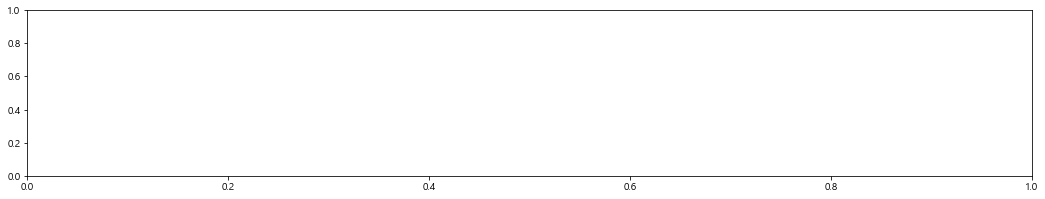

In [28]:
fig, ax = plt.subplots(figsize=(18,50))


for i in range(len(df_kpeb2.columns)):
    plt.subplot(len(df_kpeb2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kpeb2.columns[i]
    plt.scatter(x=df_kpeb2['Time'], y=df_kpeb2[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

# Line plotting

In [ ]:
df_kpeb2=df_kpeb2.set_index('Time')

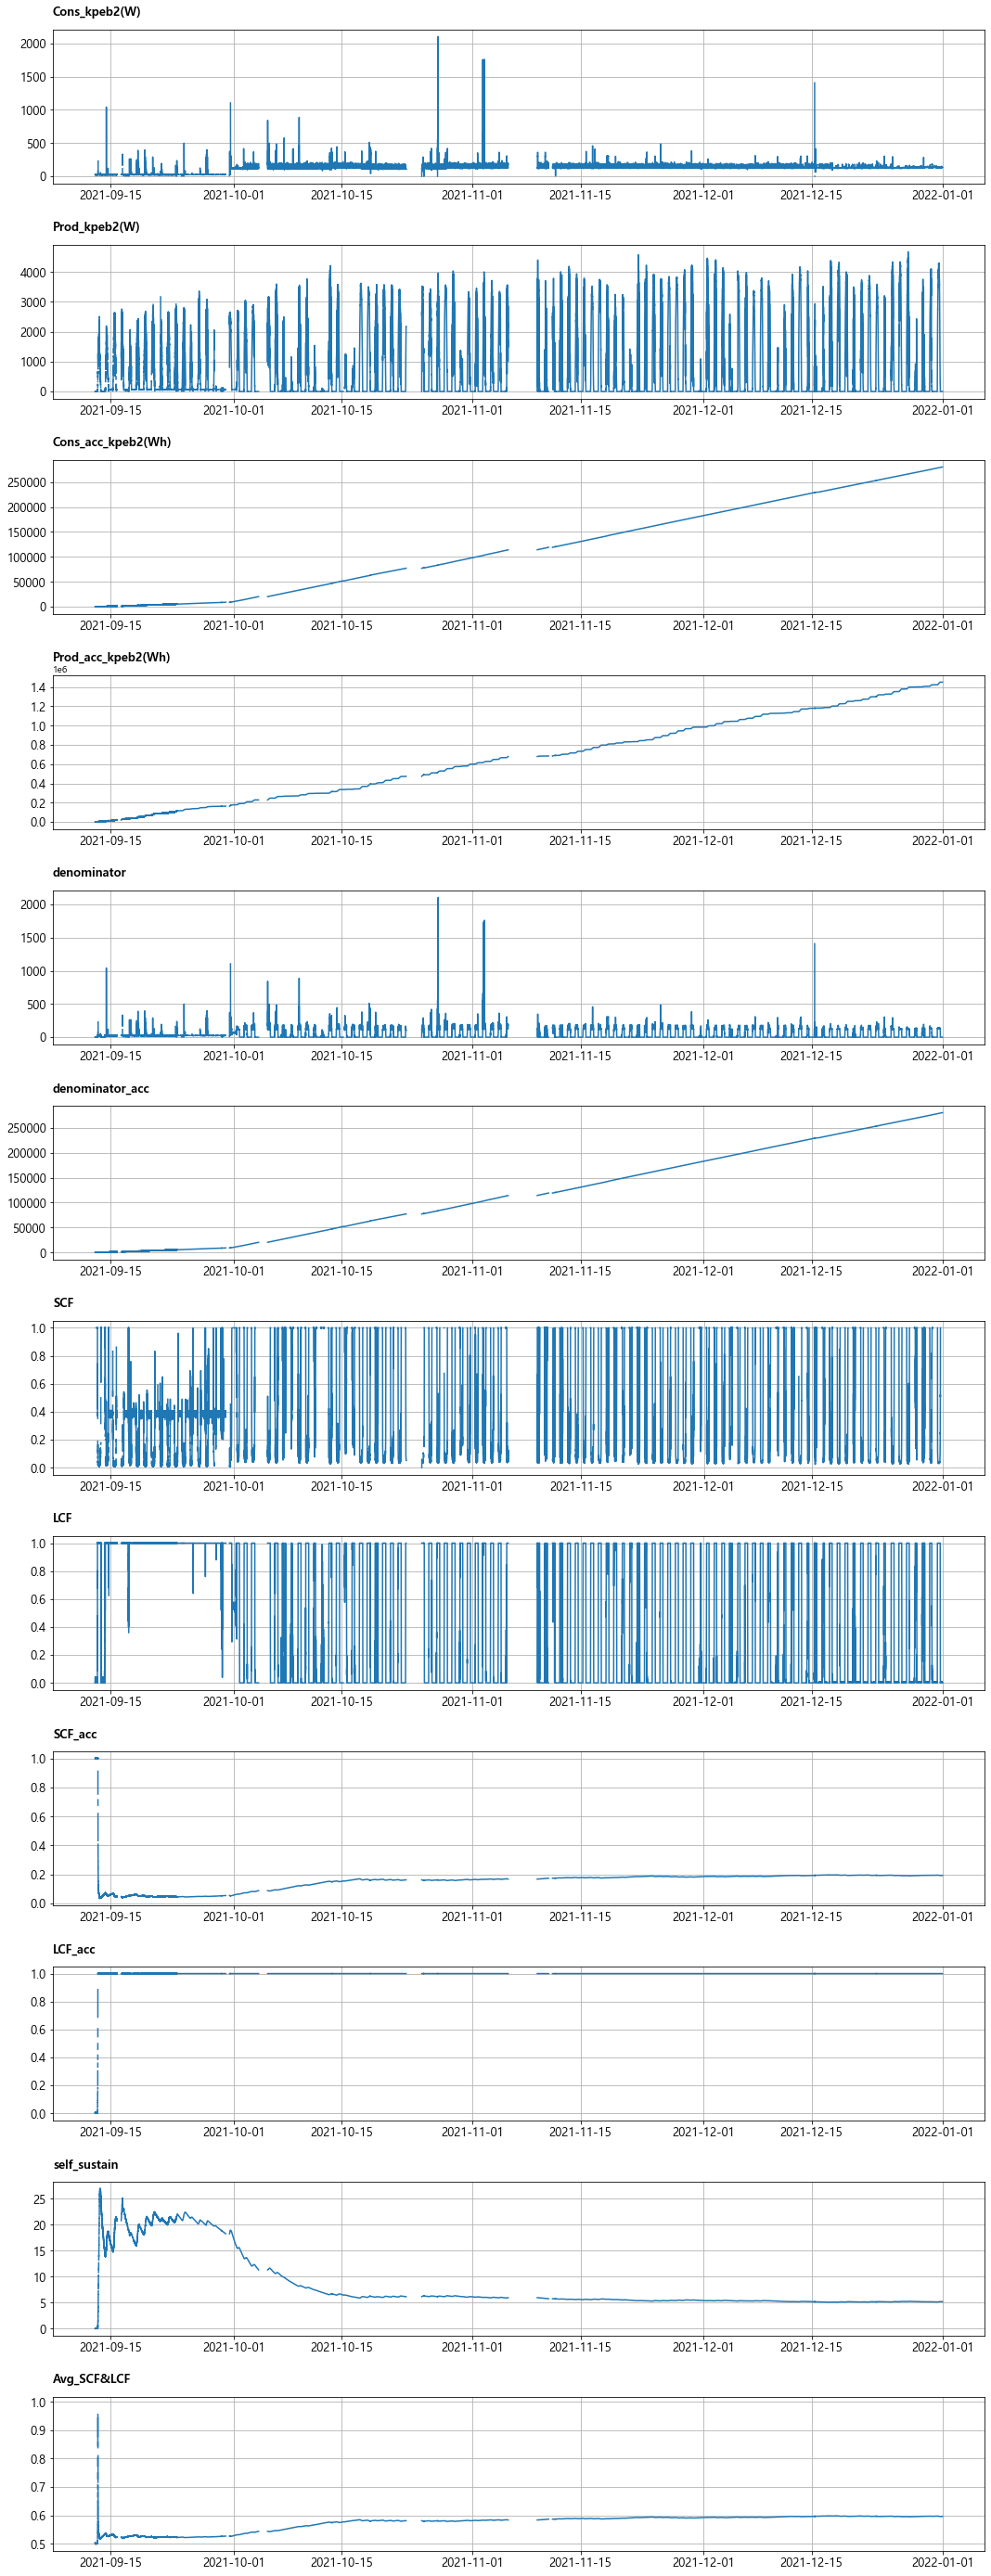

In [29]:
fig, ax = plt.subplots(figsize=(18,50))

for i in range(len(df_kpeb2.columns)):
    plt.subplot(len(df_kpeb2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpeb2.columns[i]
    plt.plot(df_kpeb2[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
#     plt.xlim(pd.Timestamp('2020-11-01'), pd.Timestamp('2021-08-31'))    
    plt.grid(True)
plt.show()
fig.tight_layout()